In [1]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [3]:


df = pd.read_csv(r'C:\Users\Pranav Desai\Desktop\Chronic Disease\Augmented kidney_dataset.csv')


In [4]:
x = df.drop("classification", axis=1).values
y = df["classification"].values


In [5]:
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
model = Sequential([
    Dense(512, kernel_regularizer=l2(0.001), input_shape=(x_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])


In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
early_stop = EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)


In [10]:
history = model.fit(x_train, y_train, epochs=52, batch_size=32,validation_split=0.2,callbacks=[early_stop, reduce_lr],verbose=1)


Epoch 1/52
200/200 [==============================] - 5s 14ms/step - loss: 0.9261 - accuracy: 0.9133 - val_loss: 0.7654 - val_accuracy: 0.9800
Epoch 2/52
200/200 [==============================] - 3s 13ms/step - loss: 0.6916 - accuracy: 0.9809 - val_loss: 0.5989 - val_accuracy: 0.9931
Epoch 3/52
200/200 [==============================] - 3s 14ms/step - loss: 0.5728 - accuracy: 0.9905 - val_loss: 0.4884 - val_accuracy: 1.0000
Epoch 4/52
200/200 [==============================] - 3s 15ms/step - loss: 0.4714 - accuracy: 0.9917 - val_loss: 0.4018 - val_accuracy: 1.0000
Epoch 5/52
200/200 [==============================] - 3s 15ms/step - loss: 0.4112 - accuracy: 0.9867 - val_loss: 0.3370 - val_accuracy: 1.0000
Epoch 6/52
200/200 [==============================] - 3s 15ms/step - loss: 0.3300 - accuracy: 0.9933 - val_loss: 0.2716 - val_accuracy: 1.0000
Epoch 7/52
200/200 [==============================] - 3s 15ms/step - loss: 0.2794 - accuracy: 0.9922 - val_loss: 0.2258 - val_accuracy: 1.0000

In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


63/63 [==============================] - 0s 5ms/step - loss: 0.0354 - accuracy: 1.0000
Test Accuracy: 1.0000


In [12]:
y_pred = model.predict(x_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1250
           1       1.00      1.00      1.00       750

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # Some versions use 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)


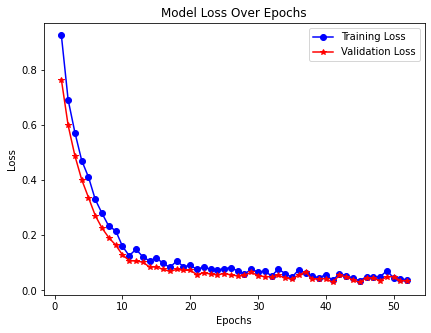

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

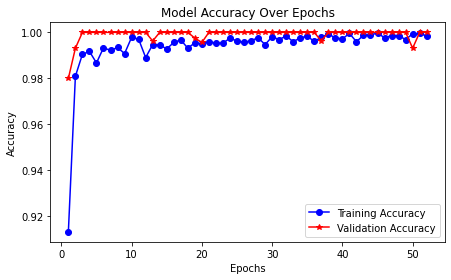

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
import tensorflow as tf
import os
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics"):
    results = {}

    # Total Parameters
    results['total_parameters'] = model.count_params()

    # FLOPs Calculation
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    flops = model_analyzer.profile(
        graph=frozen_func.graph,
        options=ProfileOptionBuilder.float_operation()
    ).total_float_ops
    results['FLOPs'] = flops
    results['GFLOPs'] = flops / 1e9

    # Model Size
    model_path = f"{model_name}.h5"
    model.save(model_path)
    size_bytes = os.path.getsize(model_path)
    results['model_size_bytes'] = size_bytes
    results['model_size_MB'] = size_bytes / (1024 * 1024)

    # Inference Time
    start = time.time()
    model.predict(x_test)
    end = time.time()
    results['inference_time_seconds'] = end - start

    # Accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results['accuracy'] = acc

    return results

evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


{'total_parameters': 191937,
 'FLOPs': 380849,
 'GFLOPs': 0.000380849,
 'model_size_bytes': 2419480,
 'model_size_MB': 2.3073959350585938,
 'inference_time_seconds': 0.1652355194091797,
 'accuracy': 1.0}